In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import os
import pickle
# import dill as pickle

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, Dropout, MaxPooling2D
from keras.utils import to_categorical
from keras import metrics
from keras.callbacks import *
from keras import regularizers

Using TensorFlow backend.


In [2]:
def get_data_and_labels(df):
    test_data = df.as_matrix(columns=['pixels'])[:, 0]
    test_data = np.array(test_data.tolist())
    # train_data = train_data.reshape(-1, 48, 48)
    test_data = test_data.astype('float32')
    test_data /= 255
    # print(test_data[0])
    test_label = df.as_matrix(columns=['emotion'])
    test_label.shape
    test_label_1hot = to_categorical(test_label)
    test_label_1hot.shape
    return test_data, test_label_1hot, test_label

In [3]:
training = pd.read_pickle('training_set.pkl')
full_test = pd.read_pickle('full_test.pkl')
train_data, train_label_1hot, train_label = get_data_and_labels(training)
test_data, test_label_1hot, test_label = get_data_and_labels(full_test)

In [4]:
train_data_2d = np.empty(shape=(len(train_data), 48, 48))
for i in range(len(train_data_2d)):
    im = np.reshape(train_data[i], (48, 48))
    train_data_2d[i] = im
train_data_2d = train_data_2d.reshape((len(train_data), 48, 48, 1))
test_data_2d = np.empty(shape=(len(test_data), 48, 48))
for i in range(len(test_data_2d)):
    im = np.reshape(test_data[i], (48, 48))
    test_data_2d[i] = im
test_data_2d = test_data_2d.reshape((len(test_data), 48, 48, 1))


In [5]:
from keras.models import load_model, model_from_json
from IPython.display import clear_output

# def save_model(model, name, cnn_history):
#     model_json = model.to_json()
#     with open(name+'.json', 'w') as json_file:
#         json_file.write(model_json)
#     model.save_weights(name+'.h5')
#     pickle.dump(cnn_history, open(name+'.p', 'wb'))
#     print('Saved to: {}'.format(name+'.json/.h5'))


# def load_model(name):
#     with open(name+'.json', 'r') as json_file:
#         model = model_from_json(json_file.read())
#     model.load_weights(name+'.h5')
#     history = pickle.load(open(name+'.p', 'rb'))
#     return model

def save_model(model, name, history):
    model.save(name)
    with open(name+'.p', 'wb') as history_file:
        pickle.dump(history, history_file)
    with open(name+'.json', 'w') as json_file:
        json_file.write(model.to_json())
    return

def load_model_(name):
    model = load_model(name)
    with open(name+'.p', 'rb') as history_file:
        history = pickle.load(history_file)
    return model, history

import sys
def plot_history(history):
    #Plot the Loss Curves
    plt.figure(figsize=[8,3])
    plt.plot(history['loss'],'r',linewidth=3.0)
    plt.plot(history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=11)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
     
    #Plot the Accuracy Curves
    plt.figure(figsize=[8,3])
    plt.plot(history['categorical_accuracy'],'r',linewidth=3.0)
    plt.plot(history['val_categorical_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=11)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
        log_string = '\n'
        for key in logs:
            log_string = log_string + '{{"metric":"{}", "value":{}}}\n'.format(key, logs[key])

        sys.__stdout__.write(str(log_string)+"\n")
        
plot = PlotLearning()

In [6]:
import plotly.offline as plty
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
plty.init_notebook_mode(connected=True)
def plotly_history(history, loss_key='loss', acc_key='categorical_accuracy'):
    
    loss_trace = go.Scatter(name='Loss', 
                            y=history[loss_key])
    loss_val_trace = go.Scatter(name='Valdition Loss', 
                                y=history['val_'+loss_key])
    data = [loss_trace, loss_val_trace]
    
    layout = go.Layout(title='Loss Curves', 
                       xaxis=dict(title='Epoch'))
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='loss')
    
    acc_trace = go.Scatter(name='Accuracy', 
                            y=history[acc_key])
    acc_val_trace = go.Scatter(name='Valdition Accuracy', 
                                y=history['val_'+acc_key])
    data = [acc_trace, acc_val_trace]
    
    layout = go.Layout(title='Accuracy Curves', 
                       xaxis=dict(title='Epoch'))
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='accuracy')
    
    
def plot_line(y, x_axis='Epoch', name='curve'):
    trace = go.Scatter(name=name,
                      y=y)
    layout = go.Layout(title=name, 
                       xaxis=dict(title=x_axis))
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=name)
    

def annotated_heatmap(heatmap_z):
    emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 
            4:'Sad', 5:'Surprise', 6:'Neutral'}
    z_text = np.around(heatmap_z, decimals=2)
    fig = ff.create_annotated_heatmap(heatmap_z,
                                      x=list(emotions.values())+['# '
                                                                 'of Samples'],
                                      y=list(emotions.values()),
                                      annotation_text=z_text,
                                      font_colors=['rgb(255,255,255)', 
                                                   'rgb(255,255,255)'],
                                      zauto=False,
                                       zmin = 0,
                                       zmax=1,
                                      )
    layout = go.Layout(
                       # title='Prediction Heatmap',
                       xaxis=dict(title='Predicted Classs'),
                       yaxis=dict(title='Actual Class'),
                       )
    fig['layout'].update(layout)
    iplot(fig, filename='prediction_heatmap.html')

In [7]:
nClasses = len(train_label_1hot[0])
dimData = len(train_data[0])

In [6]:
model, history = load_model_(
    './models/cnn_regu_conv_001_drop_dense_e200')

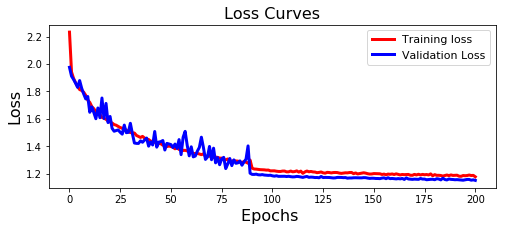

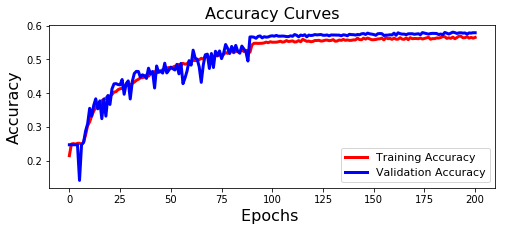

In [7]:
plot_history(history)

In [30]:
test_predictions_class = model.predict_classes(test_data, batch_size=1024)
prediction_matrix = create_confusion_matrix(test_predictions_class, test_label)

In [17]:
def create_confusion_matrix(test_predictions, test_label):
    prediction_matrix = np.zeros((nClasses, nClasses+1))
    for index, prediction in np.ndenumerate(test_predictions):
        correct_prediction = test_label[index[0], 0]
        actual_prediction = prediction
        prediction_matrix[correct_prediction, actual_prediction] = prediction_matrix[correct_prediction, actual_prediction] + 1
    for idx, row in enumerate(prediction_matrix):
        samples = np.sum(row)
        prediction_matrix[idx] = row / samples
        row[-1] = samples
    return prediction_matrix

In [31]:
test_pridictions_prob = model.predict(test_data, batch_size=1024)

In [15]:
test_pridictions_prob = pickle.load(open('./cnn_results_probs.pk', 'rb'))
test_predictions_class = pickle.load(open('./cnn_results_classes.pk', 'rb'))

In [16]:
annotated_heatmap(prediction_matrix)

NameError: name 'prediction_matrix' is not defined

In [17]:
test_label_1d = test_label.flatten()
wrong_predictions = test_predictions_classes == test_label_1d

In [18]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 
            4:'Sad', 5:'Surprise', 6:'Neutral'}

In [38]:
prediction_dict = {}
for prediction, actual, probs, idx in zip(test_predictions_class, 
                                           test_label_1d,
                                          test_pridictions_prob,
                                           range(len(test_predictions_class))):
    label = emotions[actual]
    predicted_probability = probs[prediction]
    actual_probability = probs[actual]
    if label not in prediction_dict:
        prediction_dict[label] = {'correct_idxs': [], 
                                  'wrong_idxs': [], 
                                  'key': actual}
    if prediction != actual:
        prediction_dict[label]['wrong_idxs'].append([idx, 
                                                     predicted_probability,
                                                     prediction,
                                                     actual_probability])
    else:
        prediction_dict[label]['correct_idxs'].append([idx, 
                                                       predicted_probability,
                                                       prediction,
                                                       actual_probability])
for label in prediction_dict:
    prediction_dict[label]['correct_idxs'] = sorted(prediction_dict[label]['correct_idxs'], 
                                                    key=lambda x: x[3],
                                                   reverse=True,
                                                   )
    prediction_dict[label]['wrong_idxs'] = sorted(prediction_dict[label]['wrong_idxs'], 
                                                  key=lambda x: x[3],
                                                 reverse=True,
                                                 )
    

In [20]:
from itertools import zip_longest

In [253]:
disgust_test = prediction_dict['Disgust']
wrong_idxs = disgust_test['wrong_idxs']

In [254]:
def grouper(iterable, batch_size=5, fillvalue=None):
    args = [iter(iterable)] * batch_size
    return zip_longest(*args, fillvalue=fillvalue)

for wrong_imgs in grouper(wrong_idxs):
    print(wrong_imgs)
    break

([2052, 0.34526172, 0, 0.31834319], [4203, 0.31849703, 0, 0.31621525], [5286, 0.4860321, 0, 0.31599709], [2064, 0.38383299, 0, 0.30820307], [244, 0.35335109, 3, 0.30355453])


In [22]:
idx = 0
size = 5
fontsize = 14

In [256]:
wrong_imgs = np.array(wrong_idxs[idx*size:(idx+1)*size])
# idx += 1
wrong_imgs

array([[  2.05e+03,   3.45e-01,   0.00e+00,   3.18e-01],
       [  4.20e+03,   3.18e-01,   0.00e+00,   3.16e-01],
       [  5.29e+03,   4.86e-01,   0.00e+00,   3.16e-01],
       [  2.06e+03,   3.84e-01,   0.00e+00,   3.08e-01],
       [  2.44e+02,   3.53e-01,   3.00e+00,   3.04e-01]])

In [74]:
imgs = test_data_2d[wrong_imgs[:, 0].astype('int')].reshape((size, 48, 48))

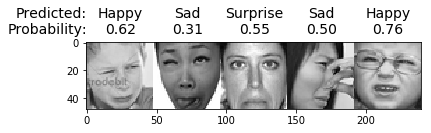

In [113]:

plt.imshow(np.hstack(imgs[:]), cmap='gray')
plt.text(x=0, y=-15, fontsize=fontsize,
         s='Predicted:\nProbability:',
         horizontalalignment='right',
         verticalalignment='center')

for img, idx in zip(wrong_imgs, range(size)):
    plt.text(x=48/2+48*idx, y=-15, fontsize=fontsize,
             s=emotions[wrong_idxs[idx][2]]+'\n' \
                 +'{:1.2f}'.format(wrong_idxs[idx][1]),
         horizontalalignment='center',
        verticalalignment='center')
plt.savefig('./images/'+'disgust_test.pdf')

In [23]:
def plot_wrong_images(test_data_2d=test_data_2d, 
                      prediction_dict=prediction_dict, 
                      label='Disgust', idx=idx, size=size):
    class_dict = prediction_dict[label]
    wrong_idxs = class_dict['wrong_idxs']
    wrong_imgs = np.array(wrong_idxs[idx*size:(idx+1)*size])
    imgs = test_data_2d[wrong_imgs[:, 0].astype('int')].reshape((size, 48, 48))
    
    fontsize = 14
    fix, ax = plt.subplots(figsize=(11, 2))
    ax.imshow(np.hstack(imgs[:]), cmap='gray')
    ax.axis('off')
    ax.text(x=0, y=-15, fontsize=fontsize,
             s='Predicted:\nProbability:',
             horizontalalignment='right',
             verticalalignment='center')
    ax.text(x=0, y=48+15, fontsize=fontsize,
             s='Actual:\nProbability:',
             horizontalalignment='right',
             verticalalignment='center')

    for img, idx in zip(wrong_imgs, range(size)):
        ax.text(x=48/2+48*idx, y=-15, fontsize=fontsize,
                 s=emotions[wrong_imgs[idx][2]]+'\n' \
                     +'{:1.3f}'.format(wrong_idxs[idx][1]),
             horizontalalignment='center',
            verticalalignment='center')
        ax.text(x=48/2+48*idx, y=48+15, fontsize=fontsize,
                 s=emotions[class_dict['key']]+'\n' \
                     +'{:1.3f}'.format(wrong_idxs[idx][3]),
             horizontalalignment='center',
            verticalalignment='center')
#     plt.savefig('./images/'+'{label}_{idx}_{size}.png')

def plot_correct_images(test_data_2d=test_data_2d, 
                      prediction_dict=prediction_dict, 
                      label='Disgust', idx=idx, size=size):
    class_dict = prediction_dict[label]
    wrong_idxs = class_dict['correct_idxs']
    wrong_imgs = np.array(wrong_idxs[idx*size:(idx+1)*size])
    imgs = test_data_2d[wrong_imgs[:, 0].astype('int')].reshape((size, 48, 48))
    fontsize = 14
    fix, ax = plt.subplots(figsize=(11, 2))
    ax.imshow(np.hstack(imgs[:]), cmap='gray')
    ax.axis('off')
    ax.text(x=0, y=-15, fontsize=fontsize,
             s='Predicted:\nProbability:',
             horizontalalignment='right',
             verticalalignment='center')
#     ax.text(x=0, y=48+15, fontsize=fontsize,
#              s='Actual:\nProbability:',
#              horizontalalignment='right',
#              verticalalignment='center')

    for img, idx in zip(wrong_imgs, range(size)):
        ax.text(x=48/2+48*idx, y=-15, fontsize=fontsize,
                 s=emotions[wrong_imgs[idx][2]]+'\n' \
                     +'{:1.3f}'.format(wrong_idxs[idx][1]),
             horizontalalignment='center',
            verticalalignment='center')
#         ax.text(x=48/2+48*idx, y=48+15, fontsize=fontsize,
#                  s=emotions[class_dict['key']]+'\n' \
#                      +'{:1.3f}'.format(wrong_idxs[idx][3]),
#              horizontalalignment='center',
#             verticalalignment='center')
#     plt.savefig('./images/'+'{label}_{idx}_{size}.png')

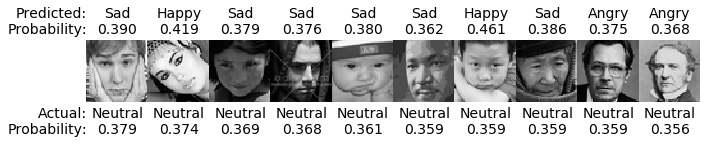

In [34]:
plot_wrong_images(label=emotions[6], size=10, idx=0)
# idx += 1

In [215]:
idx=0

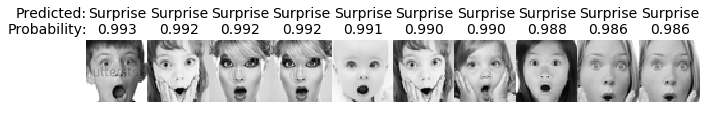

In [39]:
plot_correct_images(label='Surprise', size=10, idx=0, 
                    prediction_dict=prediction_dict)

In [41]:
prediction_dict['Happy']['correct_idxs']

[[2415, 0.99941206, 3, 0.99941206],
 [4195, 0.99894792, 3, 0.99894792],
 [701, 0.99852401, 3, 0.99852401],
 [5778, 0.99833006, 3, 0.99833006],
 [5819, 0.99807346, 3, 0.99807346],
 [6631, 0.99766016, 3, 0.99766016],
 [2261, 0.99754697, 3, 0.99754697],
 [5389, 0.99749702, 3, 0.99749702],
 [1743, 0.99725777, 3, 0.99725777],
 [4087, 0.99717242, 3, 0.99717242],
 [2431, 0.99712175, 3, 0.99712175],
 [4565, 0.99698764, 3, 0.99698764],
 [6051, 0.99693525, 3, 0.99693525],
 [4014, 0.99678814, 3, 0.99678814],
 [5060, 0.99653351, 3, 0.99653351],
 [4569, 0.99652928, 3, 0.99652928],
 [3583, 0.99647164, 3, 0.99647164],
 [6916, 0.99639112, 3, 0.99639112],
 [2354, 0.99633104, 3, 0.99633104],
 [2311, 0.99618161, 3, 0.99618161],
 [5240, 0.99616444, 3, 0.99616444],
 [5393, 0.99563062, 3, 0.99563062],
 [1899, 0.99554634, 3, 0.99554634],
 [5731, 0.9955278, 3, 0.9955278],
 [159, 0.99539524, 3, 0.99539524],
 [6533, 0.99538922, 3, 0.99538922],
 [1959, 0.99518859, 3, 0.99518859],
 [4521, 0.9951722, 3, 0.9951722]

In [30]:
type(prediction_dict['Surprise']['correct_idxs'])

list

In [ ]:
layer1_filters = 